## Example on usage of stft

In [1]:
import sys
sys.path.append('D:\GitHub\myKG')
import mySTFT
from mySTFT.stft import *
from mySTFT.stft_plot import *
import numpy as np
import scipy as sp
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
%pylab inline
#import mpld3
#mpld3.enable_notebook()

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


#### Signal to analize
import signal from wav file using the acoustic package'.

The signal imported is a recording of Balkengleisbremsen.

crop the signal to a shorter length

In [2]:
wavPath = 'D:\GitHub\myKG\Measurements_example\\various_passby\\zischen.wav'
sR, sn = read(wavPath)

### stft calculations
#### Set the stft parameters

In [3]:
M = 1024*4 #1021
ola=2
R = M//ola
window = 'hann'
N = M

#### 0- pad the signal
two step of 0-fpadding arre done
-  `x` has to be a multiple of `R` such that a stft window is centered on the last and first frame. `padN` is the amount of padding at the end of signal
- `x` is padded in front and at the end with a multiple on `R` such that the sum of overlapping windows is 1 for the first non zero frame. 
These two steps are done automatic in the function `stft` if parameter invertible is set to `true`

In [4]:
x , padN = pad_to_multiple_of_hoop(sn, R)
xPadded, before,__=  pad_for_invertible(x,M,R)
#shift time such that x0 is at time 0
tPadded = (np.arange(0,len(xPadded))- before)/ sR

#### compute stft
return:
- stft array `X(m,k)`
- frequency vector `freq(k)`
- frame`f_i(m) = m*R` of the 0-padded `x`
- parameter of stft calculations

In [5]:
X, freq, f_i, param = stft(x, M=M, R=R, N=N, sR=sR, window = window, invertible = True )

#### compute inverse stft
test if signal is correctly reconstructed

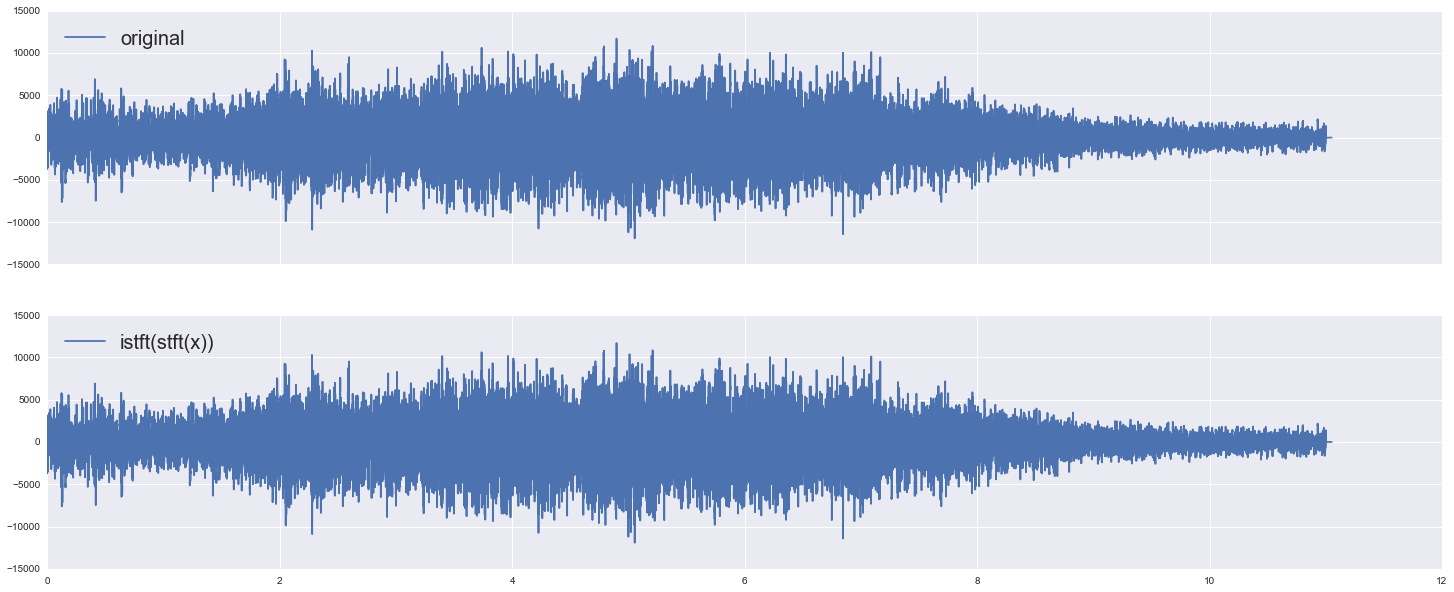

In [6]:
yPadded = istft(X,param)
padN, before , after = param['0-pad']
y = yPadded[before : - after]
np.testing.assert_array_almost_equal(x,y)
#plot
figsize(25,10)
f,ax = plt.subplots(2,sharex = True,sharey=True)
ax[0].plot(tPadded, xPadded, '-', label='original')
ax[0].legend(loc=2,prop={'size':20})
ax[1].plot(tPadded, yPadded, '-', label = 'istft(stft(x))')
ax[1].legend(loc=2,prop={'size':20})

#### spectrogram

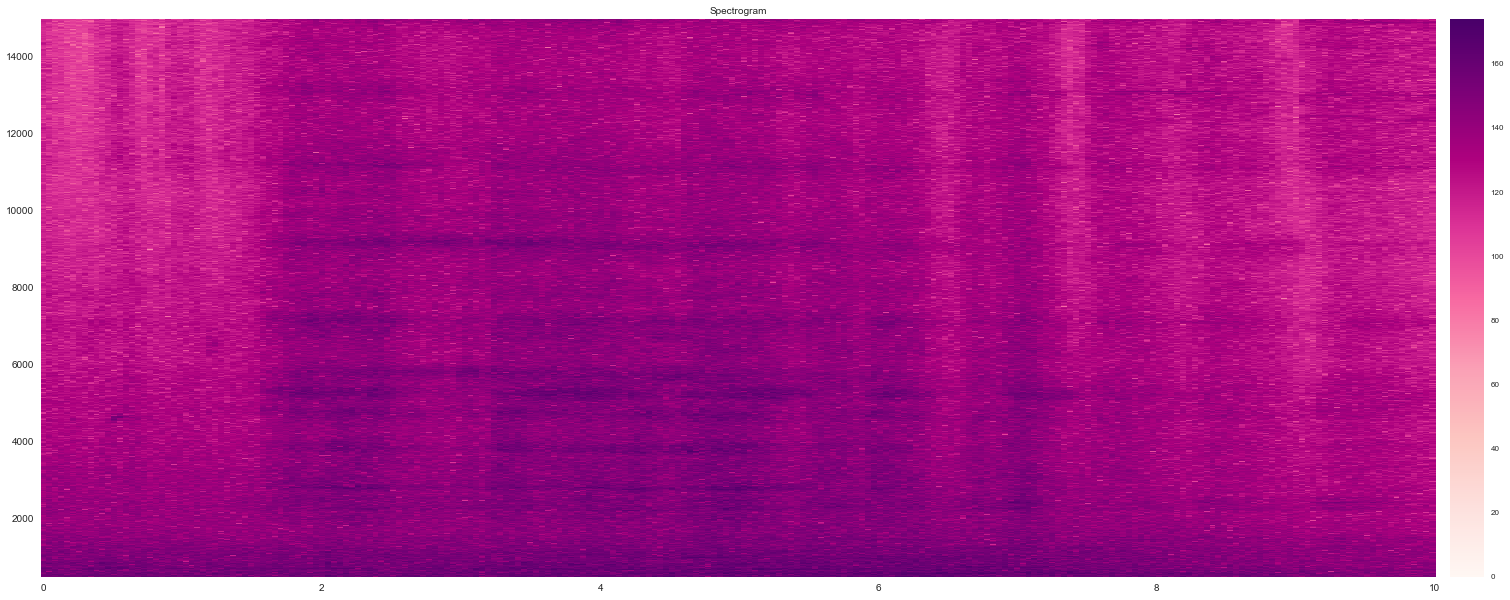

In [7]:
f,ax = plt.subplots(1,sharex = True)
plot_spectrogram(X, param, ax, freqscale = 'lin', t0 = 0, tmin = 0, tmax =10, fmin=500, fmax=15000)

####  spectrum 
calculate the spectrum directly using fft

In [8]:
N2 = len(xPadded)
Xs2 = sp.fftpack.fft(xPadded,n=N2)
df2 = sR/N2 
freq2 = sp.fftpack.fftfreq(N2,1/sR)
PSD2 = (2*abs(Xs2[1:N2//2]/sR)**2)

Calculate the spectrum using the stftand the relation $X(k) = \sum_m X(k,m)$.


In [9]:
Xs, freq = stft_spectrum(X, param)
df = sR/N
PSD = (2*abs(Xs[1:N//2]/sR)**2)

compare the  results
##### amplitude

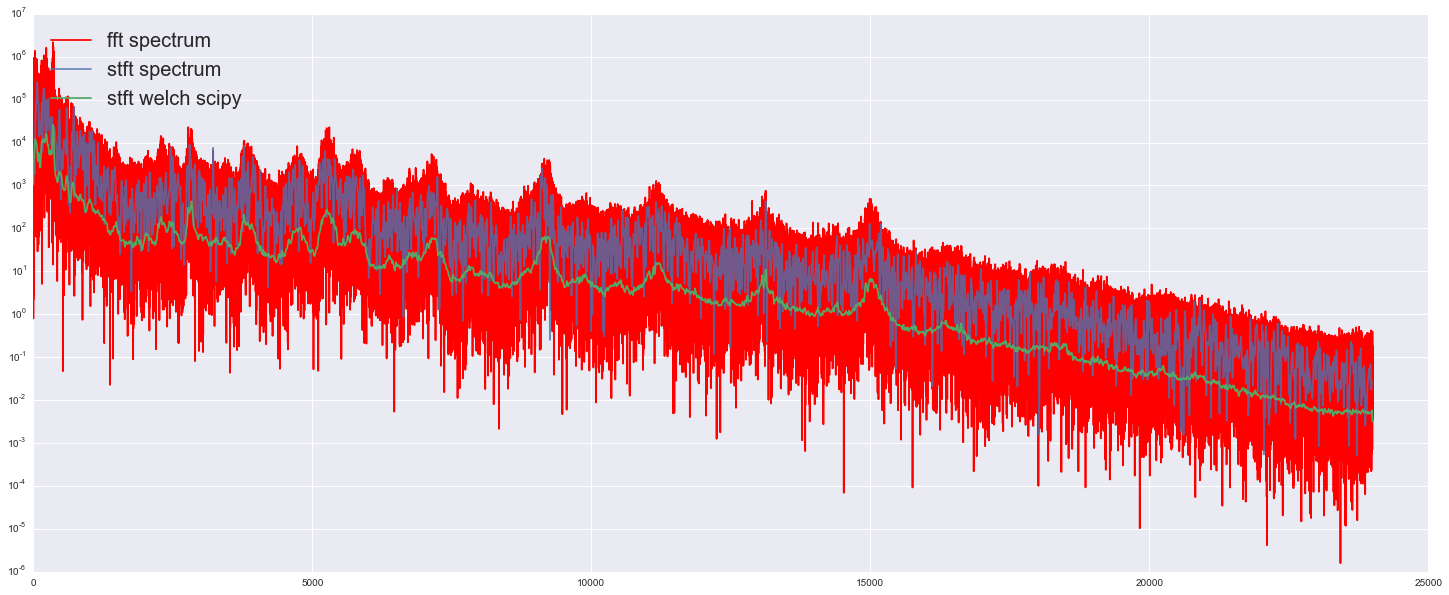

In [10]:
#scipy welch function
freqw2, PSDw2 = scipy.signal.welch(xPadded, fs=sR, window=window, nperseg = M, noverlap = M//ola, scaling = 'density')
#plot
f, ax = plt.subplots(1,sharex = True)
ax.plot(freq2[1:N2//2],PSD2,'-r',label = 'fft spectrum')
ax.plot(freq[1:N//2],PSD,'-', label = 'stft spectrum', alpha = 0.8)
ax.plot(freqw2, PSDw2,'-', label = 'stft welch scipy', alpha = 1)
ax.set_yscale('log')
ax.grid(True)
ax.legend(loc=2,prop={'size':20})

##### phase 

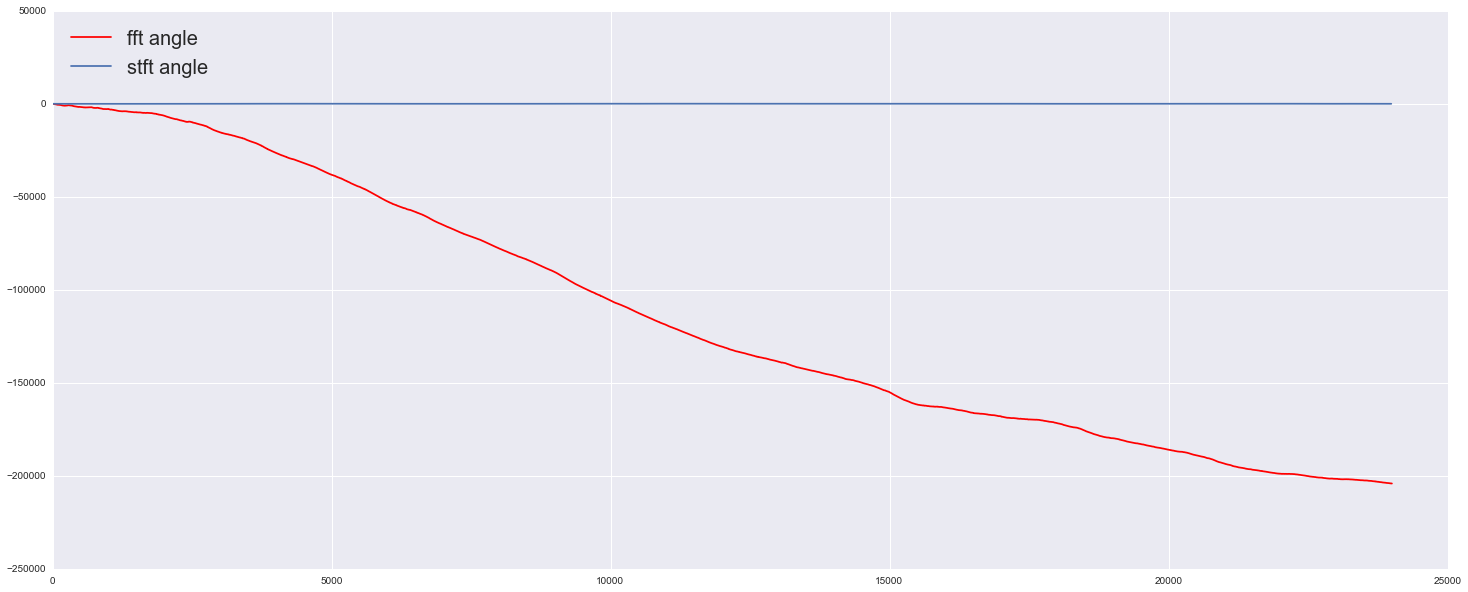

In [11]:
f, ax = plt.subplots(1,sharex = True)
ax.plot(freq2[1:N2//2], np.unwrap(np.angle(Xs2))[1:N2//2],'-r',label = 'fft angle ')
ax.plot(freq[1:N//2], np.unwrap(np.angle(Xs))[1:N//2],'-',label = 'stft angle ')
ax.grid(True)
ax.legend(loc=2,prop={'size':20})

#### welch
Calculate using the welch algorithm

In [12]:
PSDw, freqw = stft_welch(X, param, scaling = 'density')
#scipy welch function
freqw2, PSDw2 = scipy.signal.welch(xPadded, fs=sR, window=window, nperseg = M, noverlap = M//ola, scaling = 'density')

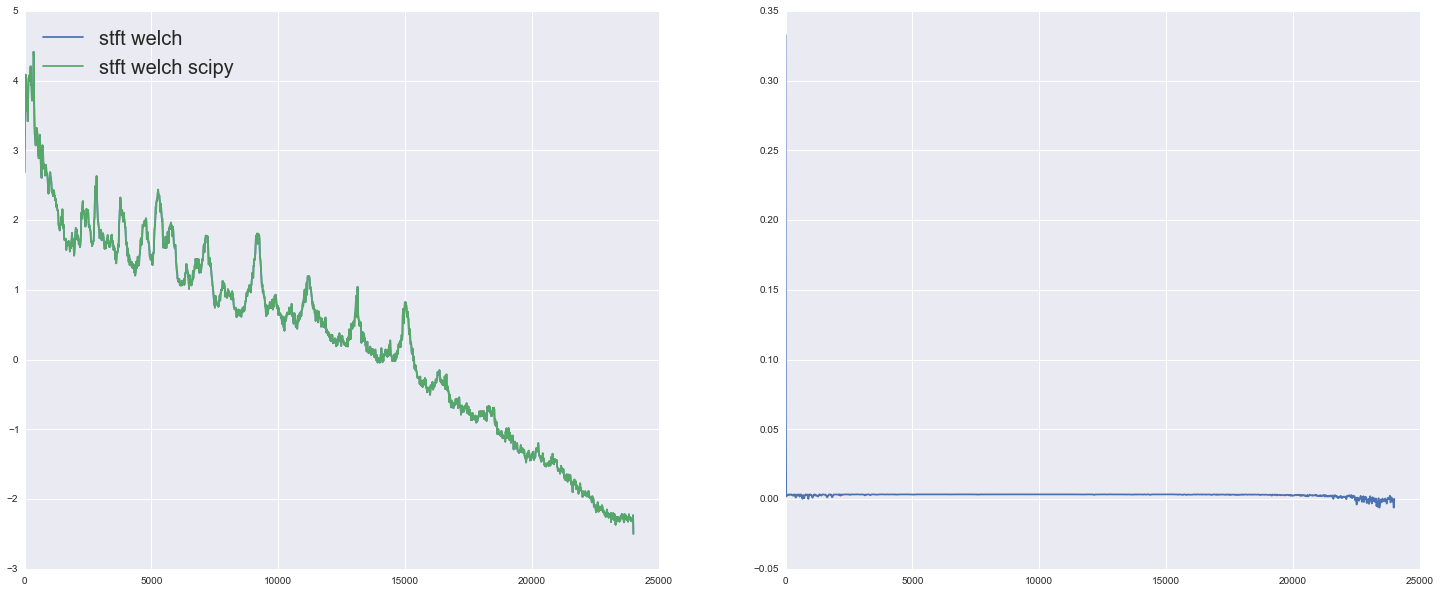

In [13]:
f, ax = plt.subplots(1,2,sharex = True)
ax[0].plot(freqw, np.log10(PSDw),'-', label = 'stft welch', alpha = 1)
ax[0].plot(freqw2, np.log10(PSDw2),'-', label = 'stft welch scipy', alpha = 1)
ax[1].plot(freqw, np.log10(PSDw2/PSDw),'-', label = 'stft welch scipy', alpha = 1)
ax[0].grid(True)
ax[0].legend(loc=2,prop={'size':20})

#### Energy, db
we test the realtion $\sum_k PSD(k)\, df = \frac{1}{N}\sum_n x_n^2 $

In [14]:
Ew = (stft_welch(X, param, scaling = 'density')[0]*df).sum()
Ew2 = (scipy.signal.welch(xPadded, fs=sR, window=window, nperseg = M, noverlap = M//ola, scaling = 'density')[1]*df).sum() 
E = (xPadded**2).mean()
print(Ew,Ew2,E)

4468607.83131 4.51199e+06 483.801215234
